c:\Users\Georgi\test_gluon\gluon_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:__main__:MPS not available. Using CPU.
INFO:__main__:Successfully fetched history production data.
INFO:__main__:Successfully fetched history production data.


INFO:__main__:Successfully fetched weather data.
INFO:__main__:Combined production and weather data:
INFO:__main__:Successfully fetched weather data.
INFO:__main__:Future covariates prepared:


Beginning AutoGluon training... Time limit = 3000s
AutoGluon will save models to 'c:\Users\Georgi\test_gluon\AutogluonModels\ag_custom'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       5.75 GB / 15.75 GB (36.5%)
Disk Space Avail:   86.21 GB / 237.84 GB (36.2%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': '15min',
 'hyperparameters': {'DeepAR': {'batch_size': 32,
                                'early_stop_patience': 5,
                                'epochs': 2,
                                'learning_rate': 0.001,
                                'verbose': 1}},
 'known_covariates_names': ['temperature_2m',
                            'cloud_cover',
                            'cloud_cover_low',
                            'wind_speed_10m',
      

****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.632341       2.103687          22.249784          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


INFO:__main__:Evaluation score: {'WQL': -0.62817520215477}
INFO:__main__:Model info: {'path': 'c:\\Users\\Georgi\\test_gluon\\AutogluonModels\\ag_custom', 'version': '1.2', 'time_fit_training': 24.460046768188477, 'time_limit': 2999.9532301425934, 'best_model': 'DeepAR', 'best_model_score_val': -0.6323411929593746, 'num_models_trained': 1, 'model_info': {'DeepAR': {'name': 'DeepAR', 'model_type': 'MultiWindowBacktestingModel', 'eval_metric': WQL, 'fit_time': 22.249783515930176, 'predict_time': 2.103687047958374, 'freq': '15min', 'prediction_length': 288, 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'val_score': -0.6323411929593746, 'hyperparameters': {'epochs': 2, 'learning_rate': 0.001, 'batch_size': 32, 'verbose': 1, 'early_stop_patience': 5}, 'info_per_val_window': [{'window_index': 0, 'refit_this_window': True, 'fit_time': 22.232657194137573, 'val_score': -0.6323411929593746, 'predict_time': 2.103687047958374}]}}}
INFO:__main__:The best model is: DeepAR
Computi

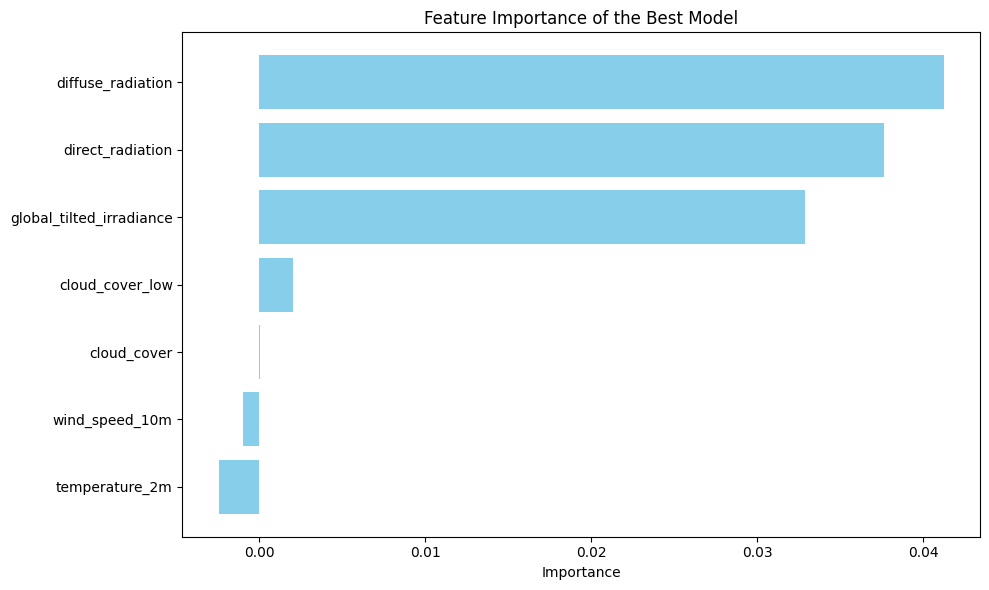

In [1]:
import os
import logging
from datetime import datetime, timedelta
import pandas as pd
import pandas as pd_f

import matplotlib.pyplot as plt

import numpy as np
import requests
import requests_cache
from retry_requests import retry
import plotly.graph_objects as go

import torch
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import openmeteo_requests

import plotly.offline as pyo

import plotly.io as pio



# ------------------------------------------------
# Setup Logging and Plotly Configurations
# ------------------------------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
#pio.renderers.default = "browser"  # Opens Plotly figures in your browser

# ------------------------------------------------
# Setup Requests Caching and Retry Mechanism
# ------------------------------------------------
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# ------------------------------------------------
# Check for Apple MPS (GPU) Availability (Using MPS if available)
# ------------------------------------------------
if torch.backends.mps.is_available():
    logger.info("MPS (Apple GPU) is available. Using MPS for GPU acceleration.")
    device = "mps"
else:
    logger.info("MPS not available. Using CPU.")
    device = "cpu"

# ------------------------------------------------
# Function to Fetch Production Data
# ------------------------------------------------
def fetch_production_data(start_date: str, forecast_date: str) -> pd.DataFrame:
    url = (f'http://209.38.208.230:8000/api/pvmeasurementdata/'
           f'?start_date={start_date}&end_date={forecast_date}&ppe=590310600030911897')
    try:
        response = requests.get(url=url)
        response.raise_for_status()
        data = response.json()
        logger.info("Successfully fetched history production data.")
        return pd.DataFrame(data)
    except requests.exceptions.RequestException as e:
        logger.error(f"Error fetching production data: {e}")
        return pd.DataFrame()
   #
   # 
def fetch_production_data_future(start_date: str, forecast_date: str) -> pd_f.DataFrame:
    url = (f'http://209.38.208.230:8000/api/pvmeasurementdata/'
           f'?start_date={start_date}&end_date={forecast_date}&ppe=590310600030911897')
    try:
        response = requests.get(url=url)
        response.raise_for_status()
        data = response.json()
        logger.info("Successfully fetched actual production data.")
        return pd_f.DataFrame(data)
    except requests.exceptions.RequestException as e:
        logger.error(f"Error fetching production data: {e}")
        return pd_f.DataFrame()

    #
# ------------------------------------------------
# Function to Clean Production Data
# ------------------------------------------------
def clean_production_data(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        logger.warning("Production data is empty.")
        return df
    df['production'] = df['production'].replace(['-', 'n/e', 'N/A', 'NaN'], np.nan).astype(float)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert('Europe/Warsaw').dt.tz_localize(None)
    if df.isnull().values.any():
        logger.warning("NaNs detected in production data. Consider handling them appropriately.")
    df = df[['timestamp', 'production', 'latitude', 'longitude']].dropna()
    return df

# ------------------------------------------------
# Function to Fetch Weather Data with Error Handling
# ------------------------------------------------
def fetch_weather_data(start: str, end: str, 
                       url_weather: str = "https://archive-api.open-meteo.com/v1/archive") -> pd.DataFrame:
    try:
        lat = float(df_dam['latitude'].iloc[0])
        lon = float(df_dam['longitude'].iloc[0])
    except Exception as e:
        logger.error(f"Error retrieving latitude and longitude: {e}")
        return pd.DataFrame()
    
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,    
        "end_date": end,
        "hourly": ["temperature_2m", "cloud_cover", "cloud_cover_low",
                   "wind_speed_10m", "direct_radiation", "diffuse_radiation",
                   "global_tilted_irradiance"],
        "tilt": 30
        # azimuth: 180 (south)
    }
    try:
        responses = openmeteo.weather_api(url_weather, params=params)
        response_weather = responses[0]
        hourly = response_weather.Hourly()
        # Extract weather variables
        hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
        hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
        hourly_cloud_cover_low = hourly.Variables(2).ValuesAsNumpy()
        hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
        hourly_direct_radiation = hourly.Variables(4).ValuesAsNumpy()
        hourly_diffuse_radiation = hourly.Variables(5).ValuesAsNumpy()
        hourly_global_tilted_irradiance = hourly.Variables(6).ValuesAsNumpy()
        
        # Create a date range based on API time info
        date_range = pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
        
        hourly_data = {
            "date": date_range,
            "temperature_2m": hourly_temperature_2m,
            "cloud_cover": hourly_cloud_cover,
            "cloud_cover_low": hourly_cloud_cover_low,
            "wind_speed_10m": hourly_wind_speed_10m,
            "direct_radiation": hourly_direct_radiation,
            "diffuse_radiation": hourly_diffuse_radiation,
            "global_tilted_irradiance": hourly_global_tilted_irradiance
        }
        hourly_df = pd.DataFrame(hourly_data)
        hourly_df["date"] = pd.to_datetime(hourly_df["date"])
        hourly_df.set_index("date", inplace=True)
        # Use "15min" to avoid FutureWarning
        resampled_df = hourly_df.resample("15min").ffill().reset_index()
        resampled_df["date"] = resampled_df["date"].dt.tz_localize(None)
        logger.info("Successfully fetched weather data.")
        return resampled_df
    except Exception as e:
        logger.error(f"Error fetching weather data: {e}")
        return pd.DataFrame()

# ------------------------------------------------
# Main Pipeline
# ------------------------------------------------
if __name__ == '__main__':
   
    # Define start and end dates for production data
    start_date = '2025-01-01'
    forecast_date = '2025-02-01'
    future_date = '2025-02-05'

    forecast_horizont = 3
    history_horizont = -3 # for the visualizations
    
    
    # Fetch and clean production data
    df_raw = fetch_production_data(start_date,forecast_date)
    df_dam = clean_production_data(df_raw)
    df_future = fetch_production_data(forecast_date, datetime.strptime(forecast_date, '%Y-%m-%d') + timedelta(days=forecast_horizont))

    if df_dam.empty:
        logger.error("Production data is empty. Exiting.")
        raise SystemExit("No production data available.")
    
    
    # ------------------------------------------------
    # Visualization 1: Production Heatmap (Plotly)
    # ------------------------------------------------
    try:
        df_vis = df_dam.copy()
        df_vis['WeekNumber'] = df_vis['timestamp'].dt.isocalendar().week
        df_weeks = df_vis[(df_vis['WeekNumber'] >= 1) & (df_vis['WeekNumber'] <= 52)]
        df_weeks['Date'] = df_weeks['timestamp'].dt.date
        df_weeks['Hour'] = df_weeks['timestamp'].dt.hour
        
        aggregated_data = df_weeks.groupby(['Hour', 'Date', 'WeekNumber'])['production'].mean().reset_index()
        heatmap_data = aggregated_data.pivot(index='Hour', columns='Date', values='production')
        
        fig_heat = go.Figure(data=go.Heatmap(
            z=heatmap_data.values,
            x=heatmap_data.columns.astype(str),
            y=heatmap_data.index,
            colorscale='Viridis',
            colorbar=dict(title="Production")
        ))
        fig_heat.update_layout(
            title='DAM Market Production Heatmap',
            xaxis_title='Date',
            yaxis_title='Hour of Day',
            yaxis_nticks=24,
            height=600
        )
        fig_heat.show()
    except Exception as e:
        logger.error(f"Error during production heatmap visualization: {e}")
    
    # ---------------------------------------------------------------------
    # Visualization 2: Hourly Production Over Time (Plotly)
    # ---------------------------------------------------------------------
    try:
        # Create an interactive scatter line plot for production over time
        fig_ts = go.Figure()
        fig_ts.add_trace(go.Scatter(
            x=df_weeks['timestamp'],
            y=df_weeks['production'],
            mode='lines+markers',
            name='Production'
        ))
        fig_ts.update_layout(
            title="Hourly Production Over Time",
            xaxis_title="Date and Hour",
            yaxis_title="Production",
            template="plotly_white"
        )
        fig_ts.show()
    except Exception as e:
        logger.error(f"Error during time series visualization: {e}")
    
    # ------------------------------------------------
    # Fetch Weather Data and Merge with Production Data
    # ------------------------------------------------
    resampled_df = fetch_weather_data(start_date, forecast_date)
    if resampled_df.empty:
        logger.error("Weather data is empty. Exiting.")
        raise SystemExit("No weather data available.")
    
    combined_df = pd.merge(df_dam, resampled_df, how='inner',
                           left_on='timestamp', right_on='date')
    combined_df.drop(columns=['date', 'latitude', 'longitude'], inplace=True)
    combined_df.dropna(inplace=True)
    combined_df = combined_df.iloc[:-1]  # Remove last row if needed
    logger.info("Combined production and weather data:")
    #logger.info(combined_df.tail())
    
    # ------------------------------------------------
    # Prepare Future Covariates (Forecast Data)
    # ------------------------------------------------
   
    start_date_val = forecast_date
    end_date_val = (datetime.strptime(forecast_date, '%Y-%m-%d') + timedelta(days=3)).strftime('%Y-%m-%d')
    forecast_df = fetch_weather_data(start_date_val, end_date_val, 
                                     url_weather="https://api.open-meteo.com/v1/forecast")
    if forecast_df.empty:
        logger.error("Forecast weather data is empty. Exiting.")
        raise SystemExit("No forecast weather data available.")
    
    forecast_df.rename(columns={'date': 'timestamp'}, inplace=True)
    forecast_df["item_id"] = "series_1"
    forecast_df = forecast_df.iloc[:288]  # Limit to prediction length
    
    if len(forecast_df) < 288:
        raise ValueError("Insufficient future covariates. Extend forecast horizon.")

    future_covariates = TimeSeriesDataFrame.from_data_frame(
        forecast_df.iloc[:288],  # Limit to prediction length
        id_column="item_id",
        timestamp_column="timestamp"
        )
    
    known_covariates = ["temperature_2m", "cloud_cover", "cloud_cover_low",
                        "wind_speed_10m", "direct_radiation", "diffuse_radiation",
                        "global_tilted_irradiance"]
    logger.info("Future covariates prepared:")
   # logger.info(future_covariates)
    
    # ------------------------------------------------
    # Visualization: Forecasted Weather Trends
    # ------------------------------------------------
    try:
        fig_forecast = go.Figure()
        
        # Add key weather variables to the plot
        fig_forecast.add_trace(go.Scatter(
            x=forecast_df["timestamp"],
            y=forecast_df["temperature_2m"],
            mode="lines",
            name="future temperature (°C)"
        ))
        fig_forecast.add_trace(go.Scatter(
            x=forecast_df["timestamp"],
            y=forecast_df["cloud_cover"],
            mode="lines",
            name="future Cloud Cover (%)"
        ))
        fig_forecast.add_trace(go.Scatter(
            x=forecast_df["timestamp"],
            y=forecast_df["global_tilted_irradiance"],
            mode="lines",
            name="future global_tilted_irradiance (W/m²)"
        ))
        fig_forecast.add_trace(go.Scatter(
            x=df_future["timestamp"],
            y=df_future["production"],
            mode="lines",
            name="future production"
        ))

        # Update layout for readability
        fig_forecast.update_layout(
            title="Forecasted Weather Trends",
            xaxis_title="Timestamp",
            yaxis_title="Value",
            legend_title="Weather Variables",
            template="plotly_dark"
        )

        fig_forecast.show()
    except Exception as e:
        logger.error(f"Error during forecast visualization: {e}")

    # ------------------------------------------------
    # Prepare Training Data for AutoGluon
    # ------------------------------------------------
    combined_df["item_id"] = "series_1"
    target_column = 'production'
    
    train_data = TimeSeriesDataFrame.from_data_frame(
        combined_df,
        id_column="item_id",
        timestamp_column="timestamp"
    )
    
    # ------------------------------------------------
    # Define Full Hyperparameters Including DeepAR with Verbose Progress
    # ------------------------------------------------
    full_hyperparameters = { 
        "DeepAR": {
            "epochs": 2,
            "learning_rate": 1e-3,
            "batch_size": 32,
            "verbose": 1,
            "early_stop_patience": 5
        },
    }
    predictor = TimeSeriesPredictor(
        target=target_column,    
        prediction_length=288,# да се провери дължината и да се нагалси с прямао другите данни
        freq='15min',
        known_covariates_names=known_covariates,
        path="AutogluonModels/ag_custom"
    )
    
    try:
        results = predictor.fit(
            train_data=train_data,    
            time_limit=3000,           
            hyperparameters=full_hyperparameters,
            enable_ensemble=False,
            verbosity=3
        )
        
    except Exception as e:
        logger.error(f"Error during model training: {e}")
        raise SystemExit("Model training failed.")
    
    logger.info("Training completed.")
    logger.info("Leaderboard:")
    #logger.info(predictor.leaderboard())
    
    try:
        cv_results = predictor.fit_summary()
        logger.info("Fit summary:")
        logger.info(cv_results)
    except Exception as e:
        logger.error(f"Error retrieving fit summary: {e}")
    
    try:
        evaluation = predictor.evaluate(train_data)
        logger.info(f"Evaluation score: {evaluation}")
    except Exception as e:
        logger.error(f"Error during evaluation: {e}")
    
    model_info = predictor.info()
    logger.info(f"Model info: {model_info}")
    
    # ------------------------------------------------
    # Inspect the Best Model (Updated API)
    # ------------------------------------------------
    best_model_name = predictor.model_best
    logger.info(f"The best model is: {best_model_name}")
    
    try:
        best_model_info = predictor.get_model_info(best_model_name)
        logger.info("Detailed best model info:")
        logger.info(best_model_info)
    except Exception as e:
        logger.warning("Detailed best model info not available: " + str(e))
    
    # Save the predictor
    # predictor.save()
    # logger.info("Predictor saved successfully.")
       
    # ------------------------------------------------
    # Visualization 4: Actual vs. Predicted Production (Plotly)
    # ------------------------------------------------
    # try:
    #     predictions_best = predictor.predict(data=train_data, known_covariates=future_covariates)
    #     predictions_best = predictions_best.clip(lower=0)
    #     df_pred_best = predictions_best.reset_index()
        
    #     # Assume df_validation has actual production values with 'timestamp' and 'production'
    #     if 'df_validation' in globals() and not df_validation.empty:
    #         df_val = df_validation.sort_values('timestamp')
    #     else:
    #         df_val = pd.DataFrame()  # If not available, this trace will be skipped
    #     fig_actual = go.Figure()
    #     fig_actual.add_trace(go.Scatter(
    #         x=df_pred_best['timestamp'],
    #         y=df_pred_best['mean'], #??????????
    #         mode='lines+markers',
    #         name='Predicted'
    #     ))
        
    #     fig_actual.add_trace(go.Scatter(
    #         x=df_future['timestamp'],
    #         y=df_future['production'],
    #         mode='lines+markers',
    #         name='Actual',     
    #     ))
       
    #     fig_actual.show()
    # except Exception as e:
    #     logger.error("Error visualizing actual vs. predicted production: " + str(e))


    # ------------------------------------------------
    # Visualize Model Feature Importance (if supported)
    # ------------------------------------------------
    try:
        # Compute feature importance using the training data.
        # Some models may not support this; if not, an exception will be raised.
        fi = predictor.feature_importance(data=train_data)
        logger.info("Feature importance:")
        logger.info(fi)
        
        if not fi.empty:
            # Sort the feature importances for better visualization.
            fi_sorted = fi.sort_values(by='importance', ascending=True)
            plt.figure(figsize=(10, 6))
            plt.barh(fi_sorted.index, fi_sorted['importance'], color='skyblue')
            plt.xlabel("Importance")
            plt.title("Feature Importance of the Best Model")
            plt.tight_layout()
            plt.show()
        else:
            logger.warning("Feature importance DataFrame is empty.")
    except Exception as e:
        logger.warning("Feature importance not available or error computing it: " + str(e))

In [15]:
import os
import plotly.offline as pyo

# Initialize Plotly offline mode
pyo.init_notebook_mode(connected=True)

# Define the notebook name (without file extension)
notebook_name = 'forecast_improvement_toolbox'  # Change this to your notebook's actual name

# Convert Jupyter Notebook to HTML
convert_html_cmd = f'jupyter nbconvert --to html "{notebook_name}.ipynb"'
html_status = os.system(convert_html_cmd)

if html_status == 0:  # Check if the HTML conversion was successful
    print(f'Successfully converted {notebook_name}.ipynb to HTML.')
else:
    print(f'Error: Failed to convert {notebook_name}.ipynb to HTML. Ensure Jupyter is installed.')

Error: Failed to convert forecast_improvement_toolbox.ipynb to HTML. Ensure Jupyter is installed.


In [ ]:
try:
    reference_date_start = datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=3)
    reference_date_end = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=6)

    predictions_best = predictor.predict(data=train_data, known_covariates=future_covariates)
    predictions_best = predictions_best.clip(lower=0)
    df_pred_best = predictions_best.reset_index()

    ref_actual_production = fetch_production_data_future(reference_date_start, reference_date_end)
    # fetch weather forecast
    ref_weather_forecast = fetch_weather_data(reference_date_start.strftime('%Y-%m-%d'), reference_date_end.strftime('%Y-%m-%d'))
    ref_weather_forecast.rename(columns={'date': 'timestamp'}, inplace=True)

    print(ref_actual_production.columns)
    fig_actual = go.Figure()

    # Prediction:
    fig_actual.add_trace(go.Scatter(
        x=df_pred_best['timestamp'],
        y=df_pred_best['0.9'], #?????????? Мисля, че трябва да е 0.9
        mode='lines+markers',
        name='Predicted'
    ))
    # Actual Production:
    fig_actual.add_trace(go.Scatter(
        x=ref_actual_production['timestamp'],
        y=ref_actual_production['production'],
        mode='lines+markers',
        name='Production Actual',     
    ))
    # Actual Weather top 3 features:
    fig_actual.add_trace(go.Scatter(
        x=ref_actual_production['timestamp'],
        y=ref_actual_production['global_tilted_irradiance'],
        mode='lines+markers',
        name='Tilted Irradiance Actual',     
    ))
    # fig_actual.add_trace(go.Scatter(
    #     x=ref_actual_production['timestamp'],
    #     y=ref_actual_production['diffuse_radiation'],
    #     mode='lines+markers',
    #     name='diffuse radiation',     
    # ))
    # Weather Forecast top 3 features
    fig_actual.add_trace(go.Scatter(
        x=ref_weather_forecast['timestamp'],
        y=ref_weather_forecast['diffuse_radiation'],
        mode='lines+markers',
        name='Diffuse Radiation forecast',     
    ))
    fig_actual.add_trace(go.Scatter(
        x=ref_weather_forecast['timestamp'],
        y=ref_weather_forecast['direct_radiation'],
        mode='lines+markers',
        name='direct radiation forecast',     
    ))
    fig_actual.add_trace(go.Scatter(
        x=ref_weather_forecast['timestamp'],
        y=ref_weather_forecast['global_tilted_irradiance'],
        mode='lines+markers',
        name='global tilted irradiance forecast',     
    ))
    

    
    fig_actual.show()
except Exception as e:
    logger.error("Error visualizing actual vs. predicted production: " + str(e))


Model not specified in predict, will default to the model with the best validation score: DeepAR
INFO:__main__:Successfully fetched actual production data.
INFO:__main__:Successfully fetched weather data.


Index(['id', 'timestamp', 'production', 'ppe', 'farm', 'latitude', 'longitude',
       'temperature_2m', 'uv_index', 'direct_radiation',
       'direct_radiation_forecast', 'min_production', 'max_production',
       'global_tilted_irradiance', 'global_tilted_irradiance_forecast'],
      dtype='object')
